In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr, ttest_ind
from tools import min_max_normalization, case_selection

from datetime import datetime

DATE = datetime.today().strftime("%Y-%m-%d")

In [2]:
NEGATIVES = ["SH.DYN.MORT"]

PROXIES_WEIGHT = {
    "MS.MIL.TOTL.TF.ZS": 2, # armed forces personnel
    "EG.USE.ELEC.KH.PC": 1, # electric power consumption
    "MS.MIL.XPND.GD.ZS": 1.5, # military expenditure
    "SH.DYN.MORT": 2, # mortality,
    "SH.H2O.BASW.ZS": 0.5, # basic drinking water servies
    "SH.H2O.SMDW.ZS": 1, # safely managed drinking water
}

YEARS = (2000, 2003, 2004, 2005, 2009, 2010, 2014)
SUCCESSFUL_TRANSITION = ("SRB", "UKR", "GEO")

In [3]:
def stateness_calculation(df, selected_cases=True):
    
    dataset = df.copy()
    dataset["proxy_weight"] = dataset["id"].map(PROXIES_WEIGHT)
    
    positives = dataset.loc[~dataset["id"].isin(NEGATIVES)].copy()
    negatives = dataset.loc[dataset["id"].isin(NEGATIVES)].copy()
    
    positives["norm"] = positives.groupby(["year", "id"])["value"].transform(min_max_normalization)
    negatives["norm"] = negatives.groupby(["year", "id"])["value"].transform(min_max_normalization, reverse=True)
    stateness = pd.concat([positives, negatives], ignore_index=False).sort_values(["year", "id"])
    
    stateness["proxy_score"] = stateness["norm"] * stateness["proxy_weight"] 
    g = stateness.groupby(["year", "iso3"], as_index=False)["proxy_score"].sum()
    g["stateness"] = g["proxy_score"] / sum(PROXIES_WEIGHT.values()) * 100
    g["successful_transition"] = g["iso3"].isin(SUCCESSFUL_TRANSITION).astype(int)
    g["approach"] = "fully covered"
    
    return case_selection(g) if selected_cases else g

In [4]:
data = pd.read_excel("./../data/interim/world-bank-data_2020-05-27 22_30.xlsx")
df = data.loc[data["year"].isin(YEARS) & data["id"].isin(PROXIES_WEIGHT.keys())].copy()

In [5]:
# show results for all countries
stateness_calculation(df, selected_cases=False)

,year,iso3,proxy_score,stateness,successful_transition,approach
0,2000,ARM,4.578842,57.235523,0,fully covered
1,2000,AZE,2.670696,33.383705,0,fully covered
2,2000,BLR,4.777724,59.721550,0,fully covered
3,2000,EST,4.995178,62.439728,0,fully covered
4,2000,GEO,3.210621,40.132759,1,fully covered
...,...,...,...,...,...,...
107,2014,SRB,4.086185,51.077310,1,fully covered
108,2014,TJK,0.993322,12.416525,0,fully covered
109,2014,TKM,2.223521,27.794007,0,fully covered
110,2014,UKR,4.681217,58.515209,1,fully covered


In [6]:
# show results for selected countries
stateness_calculation(df, selected_cases=True)

,year,iso3,proxy_score,stateness,successful_transition,approach
11,2000,SRB,7.342169,91.777117,1,fully covered
20,2003,GEO,3.475322,43.441524,1,fully covered
46,2004,UKR,4.718378,58.979729,1,fully covered
54,2005,KGZ,2.189408,27.367605,0,fully covered
73,2009,MDA,2.429788,30.372350,0,fully covered
86,2010,KGZ,2.273261,28.415764,0,fully covered
110,2014,UKR,4.681217,58.515209,1,fully covered


In [7]:
fully_covered_definition = stateness_calculation(df, selected_cases=True)
fully_covered_definition.to_excel(f"./../data/interim/fully-covered-definition_{DATE}.xlsx", index=False)

---

In [8]:
rcParams["font.size"] = 10
rcParams["figure.figsize"] = 16, 10

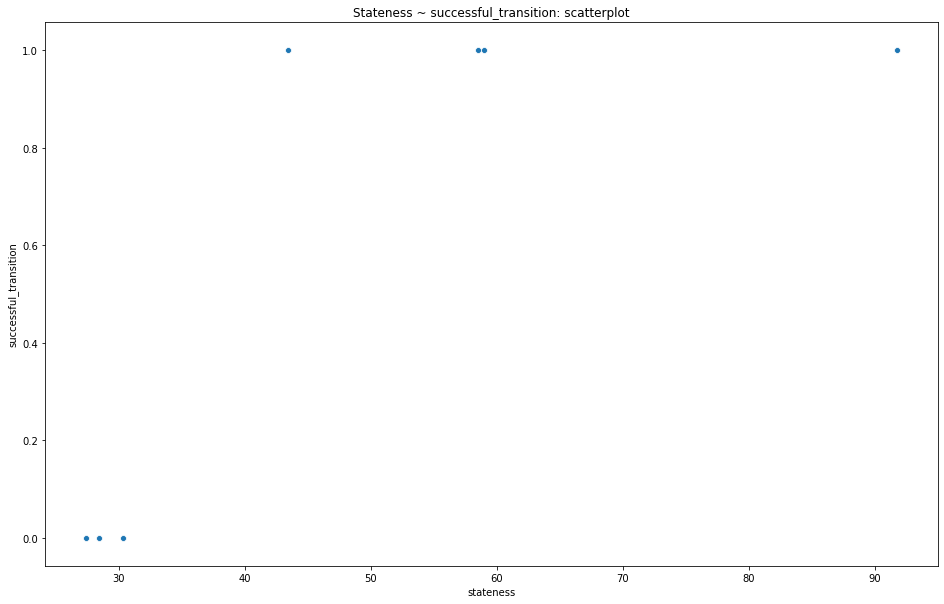

In [9]:
fig = sns.scatterplot(x="stateness", y="successful_transition", data=fully_covered_definition)
fig.set_title("Stateness ~ successful_transition: scatterplot")
plt.show()

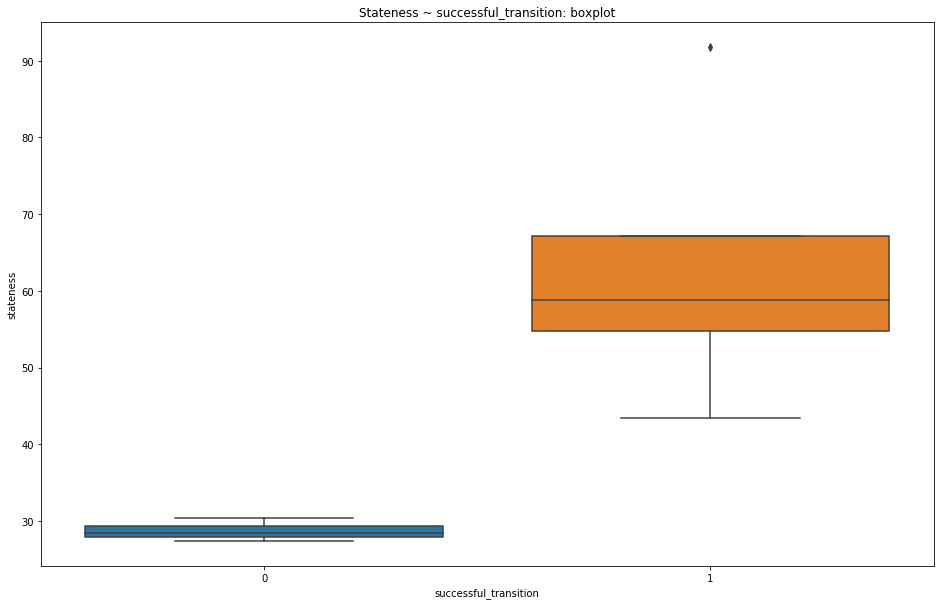

In [10]:
fig = sns.boxplot(x="successful_transition", y="stateness", data=fully_covered_definition)
fig.set_title("Stateness ~ successful_transition: boxplot")
plt.show()

In [11]:
statistic, pvalue = ttest_ind(fully_covered_definition["stateness"], fully_covered_definition["successful_transition"])

In [12]:
statistic

5.406048082523024

In [13]:
pvalue

0.00015852427631792327

In [14]:
pvalue < 0.01

True